# Poisson likelihood and Gamma prior

This is a simple model where our discrete data, $y$, is modelled as a Poisson RV with Gamma prior, which is a conjugate prior model.

$L(x) = p(y | x) = \mathcal{P}[y \mid x]$

and

$p(x) = \Gamma[x \mid k, \theta]$.

The analytic evidence for this model is,

$Z = p(y) = \int_\mathcal{X} L(x) p(x) \,\mathrm{d} x =  \mathcal{P}[y \mid 1] \frac{\Gamma[1 \mid k, \theta]}{\Gamma[1 \mid k', \theta']}$

The posterior is also a Gamma distribution,

$p(x \mid y) = \Gamma[x \mid k', \theta']$

where

$k' = k + \sum_i y_i$

and

$\theta' = \frac{\theta}{(\theta \sum_i y_i + 1)}$

In [1]:

import numpy as np
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import resample

tfpd = tfp.distributions

/home/albert/git/jaxns/jaxns/internals/mixed_precision.py:15: UserWarning: JAX x64 is not enabled. Setting it now. Check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now. Check for errors.")
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [2]:
# Generate data
np.random.seed(42)

num_samples = 10

true_k = 0.5
true_theta = 1.
_gamma = np.random.gamma(true_k, true_theta, size=num_samples)
print(f"Taking {num_samples} samples from a Poisson distribution as data.")
data = jnp.asarray(np.random.poisson(_gamma, size=num_samples))

Taking 10 samples from a Poisson distribution as data.


In [3]:

from jaxns.internals.mixed_precision import mp_policy
from jaxns import Prior, Model

# Build model
prior_k = 100.

# Note if prior_theta is chosen too large 32-bit will be insufficient
prior_theta = 0.1


def prior_model():
    lamda = yield Prior(
        tfpd.Gamma(concentration=jnp.asarray(prior_k, mp_policy.measure_dtype),
                   rate=1. / jnp.asarray(prior_theta, mp_policy.measure_dtype)),
        name='lamda')
    return lamda


def log_likelihood(lamda):
    """
    Poisson likelihood.
    """
    _log_prob = jnp.sum(tfpd.Poisson(rate=lamda).log_prob(data))
    return _log_prob


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [4]:
# Evidence and posterior are analytic
def log_gamma_prob(lamda, k, theta):
    return tfpd.Gamma(concentration=k, rate=1. / theta).log_prob(lamda)
    # return (k-1) * jnp.log(gamma)  - gamma / theta - gammaln(k) - k * jnp.log(theta)


true_post_k = prior_k + jnp.sum(data)
true_post_theta = prior_theta / (num_samples * prior_theta + 1.)

true_post_mean_gamma = true_post_theta * true_post_k

true_logZ = log_likelihood(1.) + log_gamma_prob(1., prior_k, prior_theta) - log_gamma_prob(1., true_post_k,
                                                                                           true_post_theta)
print(f"True Evidence = {true_logZ}")
print(f"True posterior concentration (k) = {true_post_k}")
print(f"True posterior rate (1/theta) = {1. / true_post_theta}")
print(f"True posterior lamda = {true_post_mean_gamma}")


True Evidence = -69.31472389012055
True posterior concentration (k) = 100.0
True posterior rate (1/theta) = 20.0
True posterior lamda = 5.0


In [5]:
from jaxns import NestedSampler

# Run the nested sampling
ns = NestedSampler(model=model, verbose=False, init_efficiency_threshold=0.)

NestedSampler(model=Model(U_ndims=1, num_params=0), max_samples=10000, num_live_points=30, s=5, k=0, c=30, num_parallel_workers=None, devices=None, difficult_model=False, parameter_estimation=False, shell_fraction=0.5, init_efficiency_threshold=0.0, verbose=False)


In [6]:


term_reason, state = ns(random.PRNGKey(3452345))

results = ns.to_results(termination_reason=term_reason, state=state)
# ns.plot_diagnostics(results)
ns.summary(results)
# ns.plot_cornerplot(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 139409
samples: 1275
phantom samples: 0
likelihood evals / sample: 109.3
phantom fraction (%): 0.0%
--------
logZ=-68.49 +- 0.94
max(logL)=-27.83
H=-21.88
ESS=72
--------
lamda: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
lamda: 4.74 +- 0.52 | 4.09 / 4.67 / 5.4 | 4.95 | 2.78
--------


/home/albert/git/jaxns/jaxns/plotting.py:48: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")
/home/albert/git/jaxns/jaxns/plotting.py:52: RuntimeWarning: divide by zero encountered in divide
  1. / num_likelihood_evaluations_per_sample


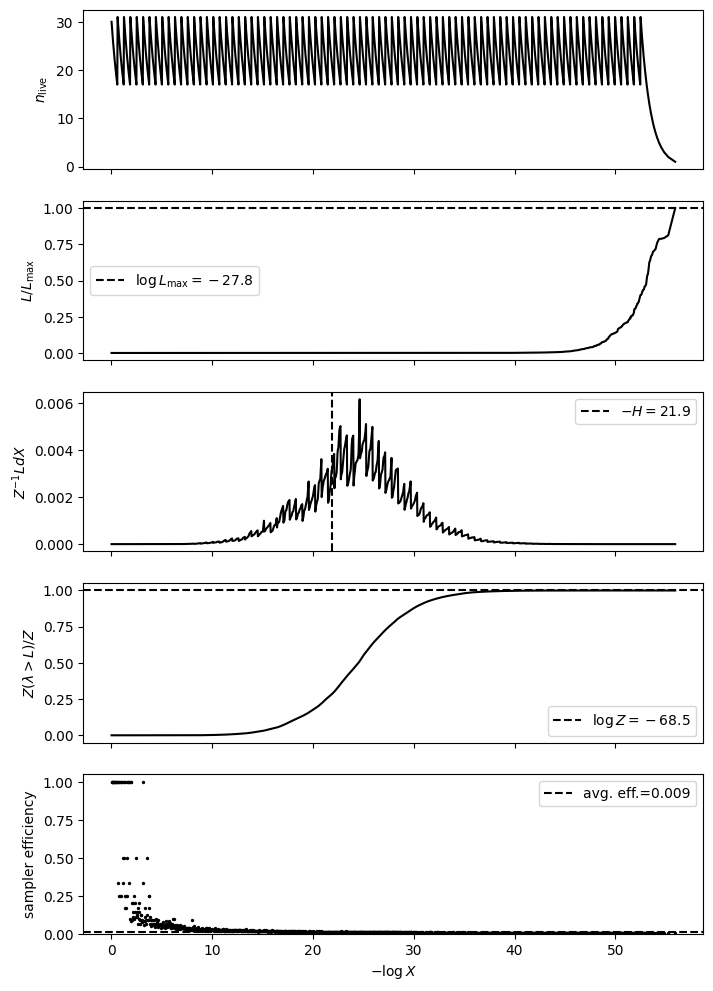

In [7]:
ns.plot_diagnostics(results)


In [8]:
sender_node_ids = state.sample_collection.sender_node_idx[:state.num_samples]
log_L = state.sample_collection.log_L[:state.num_samples]
log_L_constraint = jnp.where(sender_node_ids==0, -jnp.inf, log_L[sender_node_ids])
print(log_L_constraint)

[        -inf         -inf         -inf ... -28.74926171 -29.37857529
 -28.74926171]


In [9]:
state.sample_collection.U_samples[:state.num_samples][-10:]

Array([[9.46856173e-26],
       [8.68788809e-26],
       [8.44157651e-26],
       [8.11680136e-26],
       [6.99380909e-26],
       [6.40996985e-26],
       [6.37251786e-26],
       [6.25653556e-26],
       [5.90518418e-26],
       [3.44069476e-26]], dtype=float64)

In [10]:
from jaxns.internals.tree_structure import SampleTreeGraph, count_crossed_edges_less_fast, count_crossed_edges, \
    count_intervals_naive

sample_tree = SampleTreeGraph(sender_node_idx=sender_node_ids, log_L=log_L)
naive = count_intervals_naive(sample_tree)
less_fast = count_crossed_edges_less_fast(sample_tree)
fast = count_crossed_edges(sample_tree)
print(naive.num_live_points.tolist())
print(fast.num_live_points.tolist())
# np.testing.assert_allclose(naive.samples_indices, less_fast.samples_indices)
np.testing.assert_allclose(naive.num_live_points, less_fast.num_live_points)
# np.testing.assert_allclose(naive.samples_indices, fast.samples_indices)
# np.testing.assert_allclose(naive.num_live_points, fast.num_live_points)


/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


[30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21,

In [11]:
for idx in np.where(log_L_constraint == log_L)[0]:
    print(f"{idx} {log_L[idx - 1: idx+2]} {log_L_constraint[idx - 1: idx+2]}")
    

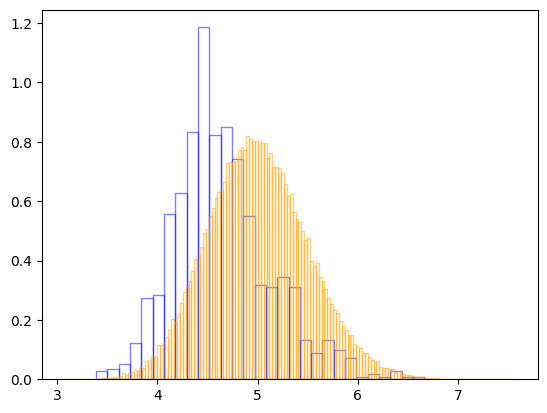

In [12]:
# Comparing samples to true posterior

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=1000)

plt.hist(samples['lamda'], bins='auto', ec='blue', alpha=0.5, density=True, fc='none')

_gamma = np.random.gamma(true_post_k, true_post_theta, size=100000)

plt.hist(_gamma, bins='auto', ec='orange', alpha=0.5, density=True, fc='none')
plt.show()